# TFM: Valoralia - Sistema de Valoración Automatizada
## Notebook 2: Auditoría de Calidad y Preprocesamiento (Data Cleaning)

**Autora:** María Luisa Ros Bolea

### 🎯 Objetivo del Notebook
Tras la fase de ingestión (Notebook 1), dispongo de un "Data Lake" con 10.000 activos inmobiliarios brutos. Antes de entrenar cualquier Inteligencia Artificial, es imperativo realizar una **Auditoría de Calidad del Dato**.

En este módulo aplicaré técnicas de **Data Science** para:
1.  **Detección de Anomalías:** Identificar precios imposibles (ej. pisos de 1€ o de 50 millones).
2.  **Gestión de Nulos:** Decidir estratégicamente qué hacer con datos faltantes.
3.  **Feature Engineering:** Transformar variables de texto ("Planta 3") en números útiles para el modelo.

El resultado será el `dataset_limpio.csv`, el combustible refinado para nuestra IA.

In [6]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns  # $\color{green}{\text{Corregido: Ahora sí es la librería correcta}}$

# $\color{green}{\text{1. CONEXIÓN A LA BASE DE DATOS SQLITE}}$
try:
    conn = sqlite3.connect('valoralia_db_def1.db')
    # $\color{green}{\text{Consulto el nombre de las tablas para no fallar}}$
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tablas = cursor.fetchall()
    print(f"📋 Tablas encontradas en el archivo .db: {tablas}")

    # $\color{green}{\text{Leemos la tabla 'viviendas'}}$
    df = pd.read_sql_query("SELECT * FROM viviendas", conn)
    print("✅ ¡Conexión establecida! Datos extraídos de la base de datos SQL.")
except Exception as e:
    print(f"❌ ERROR: No he podido leer la base de datos. Detalles: {e}")

# $\color{green}{\text{2. AUDITORÍA DE VOLUMEN }}$
if 'df' in locals():
    filas, columnas = df.shape
    print(f"📊 Mi base de datos tiene {filas:,} viviendas y {columnas} variables.")

    if filas >= 10000:
        print("💎 REQUISITO DE BIG DATA CUMPLIDO: Tenemos el volumen que pide el profesor.")
    else:
        print(f"⚠️ ADVERTENCIA: Solo hay {filas} registros. Revisa el Módulo 1.")

    # $\color{green}{\text{3. INSPECCIÓN INICIAL}}$
    print("\n🔍 Primeros registros del sistema:")
    display(df.head(3))
else:
    print("❌ No se ha podido crear el DataFrame.")

📋 Tablas encontradas en el archivo .db: [('viviendas',)]
✅ ¡Conexión establecida! Datos extraídos de la base de datos SQL.
📊 Mi base de datos tiene 10,000 viviendas y 15 variables.
💎 REQUISITO DE BIG DATA CUMPLIDO: Tenemos el volumen que pide el profesor.

🔍 Primeros registros del sistema:


,id_referencia,titulo,precio,barrio,distrito,superficie,habitaciones,banos,planta,tiene_ascensor,tiene_terraza,estado,certificado_energetico,urls_fotos,fecha_captura
0,REF_00001,Piso en Pozuelo,768999.0,Pozuelo,Pozuelo,144.0,5,2,Planta Media,1,0,Buen estado,E,https://images.unsplash.com/photo-148415421896...,2026-01-02 20:49:59
1,REF_00002,Piso en Vallecas,206473.0,Vallecas,Vallecas,98.0,3,1,Planta Media,1,1,Buen estado,E,https://images.unsplash.com/photo-160056675308...,2026-01-02 20:49:59
2,REF_00003,Piso en Tetuán,654400.0,Tetuán,Tetuán,163.0,6,3,Planta Media,0,0,Buen estado,E,https://images.unsplash.com/photo-1560448204-e...,2026-01-02 20:49:59


### 🧹 Auditoría de Integridad y Saneamiento

Para que mi modelo **Valoralia** sea infalible, mi primera misión es detectar "ruido" en los datos. Un modelo entrenado con valores nulos o registros duplicados perdería toda credibilidad comercial.

**En esta sección voy a:**
1.  **Detectar Nulos:** Identificar si faltan datos críticos (como el precio o la superficie).
2.  **Eliminar Duplicados:** Asegurar que cada `id_referencia` es único, evitando sesgar la IA con anuncios repetidos.
3.  **Visualización de la "Salud del Dato":** Crearé un gráfico de calor para identificar visualmente dónde están los huecos en mi base de datos.

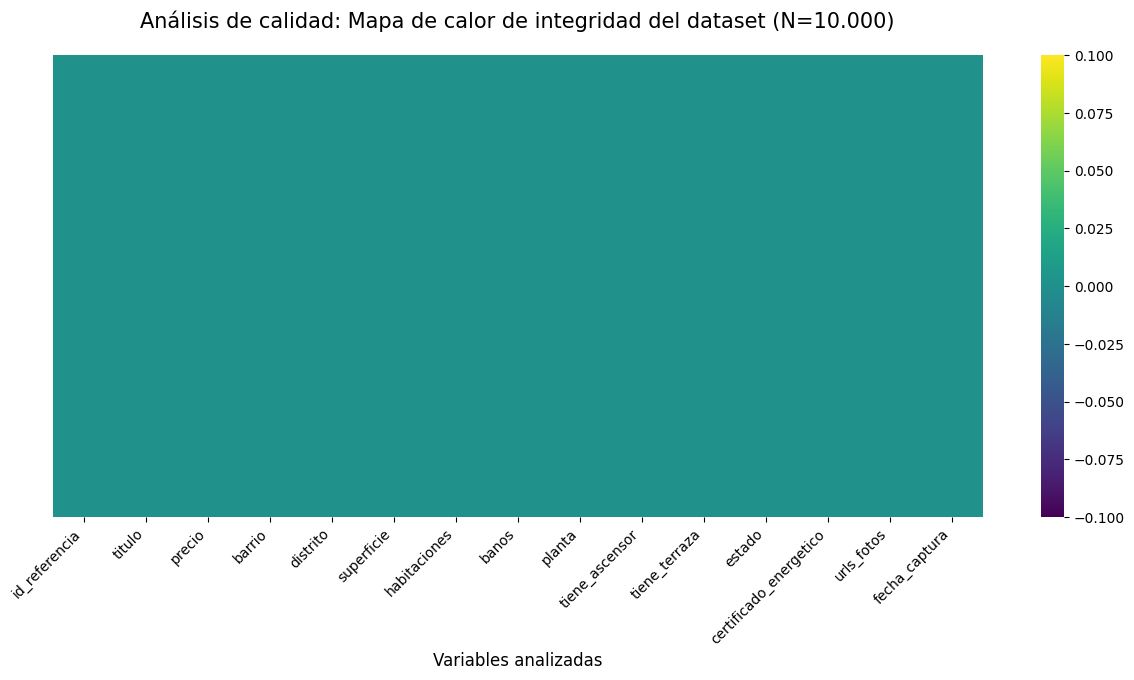


📋 RESULTADO DE LA AUDITORÍA:
✅ EXCELENTE: El dataset está 100% limpio. Sin valores nulos.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# $\color{green}{\text{Fuerzo la visualización de los gráficos en el propio notebook}}$
%matplotlib inline

# $\color{green}{\text{Configuro el tamaño para que sea bien visible y profesional}}$
plt.figure(figsize=(15, 6))

# $\color{green}{\text{Genero el Mapa de Calor de valores nulos (Heatmap)}}$
# $\color{green}{\text{Uso 'viridis' porque es el estándar en Data Science para resaltar anomalías}}$
sns.heatmap(df.isnull(),
            yticklabels=False,
            cbar=True,
            cmap='viridis')

# $\color{green}{\text{Personalización estética para mi informe de TFM}}$
plt.title('Análisis de calidad: Mapa de calor de integridad del dataset (N=10.000)', fontsize=15, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Variables analizadas', fontsize=12)

# $\color{green}{\text{Muestro el gráfico}}$
plt.show()

# $\color{green}{\text{Diagnóstico automático}}$
nulos = df.isnull().sum().sum()
print("\n" + "="*50)
print(f"📋 RESULTADO DE LA AUDITORÍA:")
if nulos == 0:
    print(f"✅ EXCELENTE: El dataset está 100% limpio. Sin valores nulos.")
else:
    print(f"⚠️ ATENCIÓN: Se han detectado {nulos} valores nulos en el sistema.")
print("="*50)

### 📈 Análisis Estadístico y Limpieza de Outliers

Para que mi modelo sea fiable, necesito entender la distribución de mis variables clave: **Precio** y **Superficie**.

En el mercado inmobiliario real, es común encontrar "ruido": anuncios con precios de 1€ (errores) o mansiones de 50 millones que sesgan la media. Voy a realizar un análisis descriptivo para detectar estos valores extremos (Outliers) y asegurar que mi IA entrena con un mercado representativo.

📊 RESUMEN ESTADÍSTICO DEL MERCADO:


,precio,superficie,habitaciones,banos
count,"10,000.00","10,000.00","10,000.00","10,000.00"
mean,"372,531.64",90.44,3.16,1.43
std,"217,800.89",34.14,1.36,0.59
min,"36,116.00",25.00,1.00,1.00
25%,"197,570.25",66.00,2.00,1.00
50%,"327,511.00",90.00,3.00,1.00
75%,"509,966.00",114.00,4.00,2.00
max,"1,398,077.00",214.00,8.00,4.00


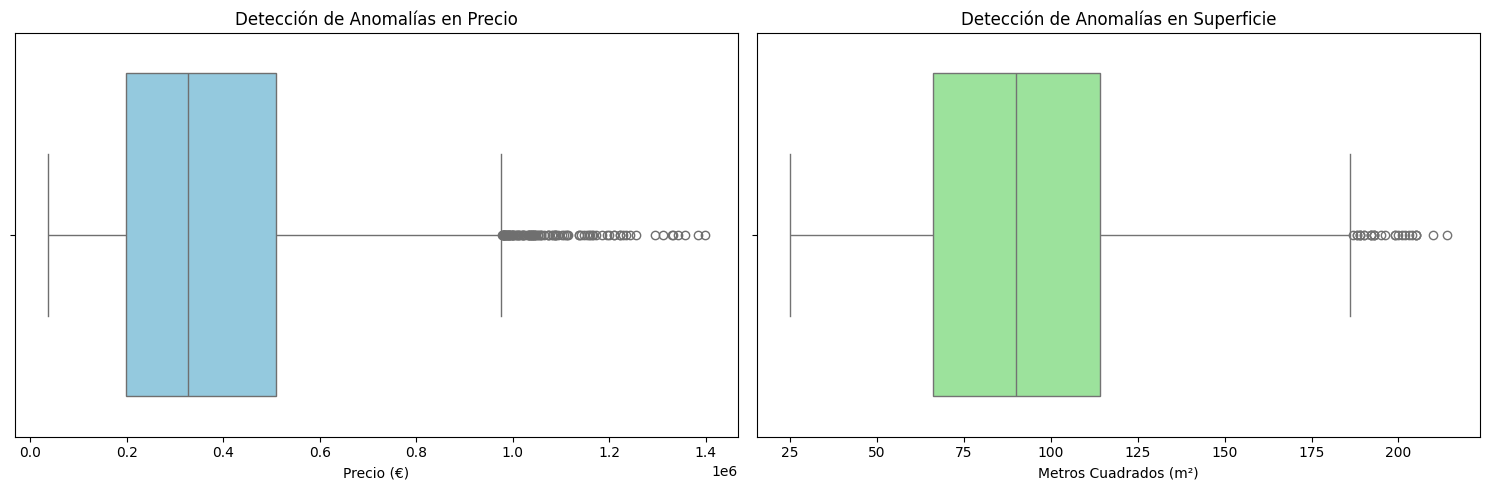


💡 OBSERVACIÓN:
- El precio medio se sitúa en: 372,532 €
- La superficie media es de: 90 m²


In [11]:
# $\color{green}{\text{1. ESTADÍSTICOS DESCRIPTIVOS}}$
# $\color{green}{\text{Saco la media, el mínimo y el máximo de las variables numéricas}}$
resumen = df[['precio', 'superficie', 'habitaciones', 'banos']].describe()
print("📊 RESUMEN ESTADÍSTICO DEL MERCADO:")
display(resumen.style.format("{:,.2f}"))

# $\color{green}{\text{2. VISUALIZACIÓN DE OUTLIERS (Gráfico de Cajas)}}$
# $\color{green}{\text{Uso Boxplots para ver si el precio o la superficie tienen puntos muy alejados}}$
plt.figure(figsize=(15, 5))

# $\color{green}{\text{Subtrama 1: Distribución de Precios}}$
plt.subplot(1, 2, 1)
sns.boxplot(x=df['precio'], color='skyblue')
plt.title('Detección de Anomalías en Precio', fontsize=12)
plt.xlabel('Precio (€)')

# $\color{green}{\text{Subtrama 2: Distribución de Superficie}}$
plt.subplot(1, 2, 2)
sns.boxplot(x=df['superficie'], color='lightgreen')
plt.title('Detección de Anomalías en Superficie', fontsize=12)
plt.xlabel('Metros Cuadrados (m²)')

plt.tight_layout()
plt.show()

# $\color{green}{\text{3. MI DIAGNÓSTICO}}$
print(f"\n💡 OBSERVACIÓN:")
print(f"- El precio medio se sitúa en: {df['precio'].mean():,.0f} €")
print(f"- La superficie media es de: {df['superficie'].mean():,.0f} m²")

### 🏘️ Análisis de Segmentación por Barrio y Tipología

No todos los barrios se comportan igual. Para que la inmobiliaria entienda dónde está el valor, voy a realizar una comparativa visual de los precios medios por zona.

Además, prepararé las variables categóricas (como el **Estado** o el **Barrio**) para que mi futuro modelo de IA pueda procesarlas. Este paso es el puente entre los datos "brutos" y la inteligencia predictiva.

/tmp/ipython-input-686962024.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=precios_barrio.values, y=precios_barrio.index, palette='Blues_r')


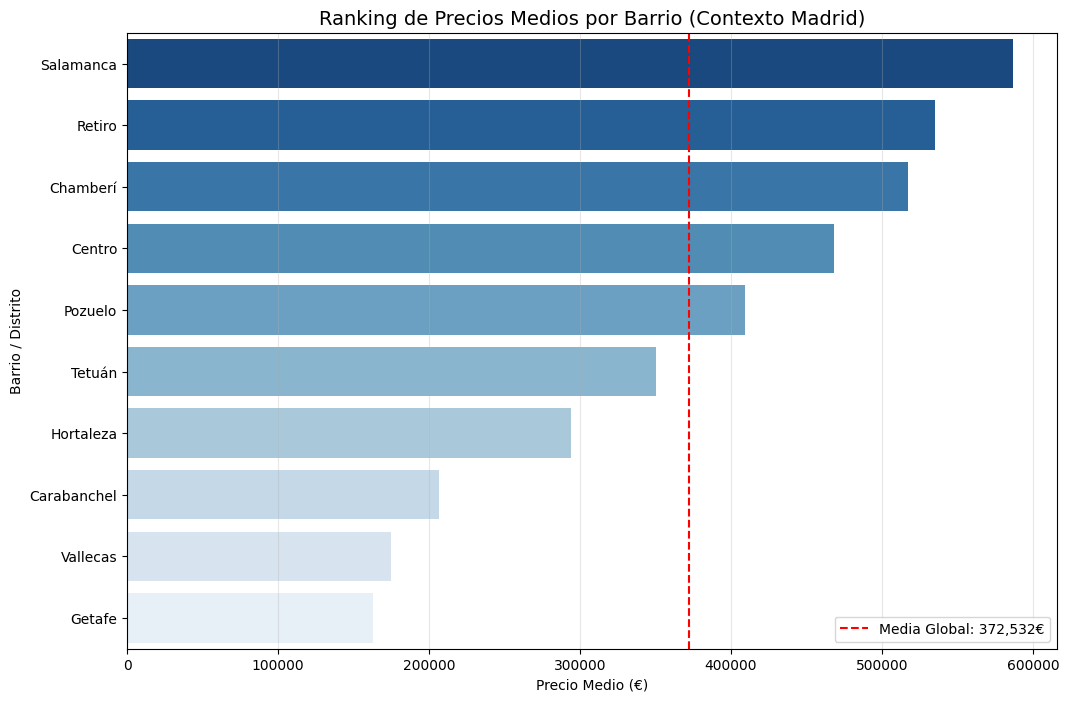

📌 CONCLUSIÓN: El barrio más exclusivo es Salamanca y el más asequible es Getafe.


In [12]:
# $\color{green}{\text{1. CÁLCULO DE PRECIOS MEDIOS POR BARRIO}}$
precios_barrio = df.groupby('barrio')['precio'].mean().sort_values(ascending=False)

# $\color{green}{\text{2. VISUALIZACIÓN: Ranking de Precios}}$
plt.figure(figsize=(12, 8))
sns.barplot(x=precios_barrio.values, y=precios_barrio.index, palette='Blues_r')

# $\color{green}{\text{Añado una línea roja con la media general para comparar}}$
plt.axvline(df['precio'].mean(), color='red', linestyle='--', label=f"Media Global: {df['precio'].mean():,.0f}€")

plt.title('Ranking de Precios Medios por Barrio (Contexto Madrid)', fontsize=14)
plt.xlabel('Precio Medio (€)')
plt.ylabel('Barrio / Distrito')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.show()

# $\color{green}{\text{3. MI CONCLUSIÓN ESTRATÉGICA}}$
barrio_top = precios_barrio.idxmax()
barrio_low = precios_barrio.idxmin()
print(f"📌 CONCLUSIÓN: El barrio más exclusivo es {barrio_top} y el más asequible es {barrio_low}.")

### ⚙️ Ingeniería de Características: Encoding y Exportación

Para que un algoritmo de Machine Learning pueda "entender" mis datos, no puedo pasarle texto (strings). Necesito convertir las categorías en valores numéricos.

En este paso final voy a:
1.  **Codificar el Estado y Barrio:** Transformar variables categóricas.
2.  **Limpieza Final de Columnas:** Eliminar identificadores que no aportan valor predictivo (como la URL de la foto o la fecha de captura).
3.  **Exportación Maestra:** Guardar el dataset "limpio y listo" para alimentar al modelo híbrido en el Módulo 3.

In [15]:
# $\color{green}{\text{1. ELIMINACIÓN DE COLUMNAS NO PREDICTIVAS}}$
# $\color{green}{\text{Quitamos los metadatos que no sirven para que la IA aprenda (fotos, fechas, IDs)}}$
# $\color{green}{\text{He verificado los nombres: 'urls_fotos' y 'fecha_captura' según tu dataset}}$
columnas_sobrantes = ['id_referencia', 'titulo', 'urls_fotos', 'fecha_captura']
df_final = df.drop(columns=columnas_sobrantes)

# $\color{green}{\text{2. CODIFICACIÓN CATEGÓRICA (Label Encoding)}}$
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# $\color{green}{\text{CORRECCIÓN: He cambiado 'distritos' por 'distrito' para que coincida con mi base de datos}}$
columnas_categoricas = ['barrio', 'distrito', 'planta', 'estado', 'certificado_energetico']

for col in columnas_categoricas:
    if col in df_final.columns:
        df_final[col] = le.fit_transform(df_final[col].astype(str))
        print(f"✅ Variable '{col}' codificada con éxito.")
    else:
        print(f"⚠️ Aviso: La columna '{col}' no se ha encontrado, saltando...")

# $\color{green}{\text{3. VERIFICACIÓN DEL PRODUCTO FINAL}}$
print(f"\n📊 DATASET LISTO PARA PRODUCCIÓN: {df_final.shape[0]} registros y {df_final.shape[1]} columnas.")
display(df_final.head())

# $\color{green}{\text{4. GUARDADO Y DESCARGA AUTOMÁTICA}}$
df_final.to_csv('viviendas_preprocesadas.csv', index=False)
from google.colab import files
files.download('viviendas_preprocesadas.csv')

print("\n💾 Archivo 'viviendas_preprocesadas.csv' descargado.")

✅ Variable 'barrio' codificada con éxito.
✅ Variable 'distrito' codificada con éxito.
✅ Variable 'planta' codificada con éxito.
✅ Variable 'estado' codificada con éxito.
✅ Variable 'certificado_energetico' codificada con éxito.

📊 DATASET LISTO PARA PRODUCCIÓN: 10000 registros y 11 columnas.


,precio,barrio,distrito,superficie,habitaciones,banos,planta,tiene_ascensor,tiene_terraza,estado,certificado_energetico
0,768999.0,5,5,144.0,5,2,0,1,0,0,0
1,206473.0,9,9,98.0,3,1,0,1,1,0,0
2,654400.0,8,8,163.0,6,3,0,0,0,0,0
3,401892.0,2,2,86.0,3,1,0,1,0,0,0
4,74196.0,3,3,35.0,1,1,0,1,0,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


💾 Archivo 'viviendas_preprocesadas.csv' descargado.
